# Reproduction of Citation-Integrity

### Authored by Jeffrey Dick on 2024-11-29

This notebook presents my reproduction of the Citation-Integrity model.

## Introduction to the model

This description was adapted from [Sarol et al. (2024)](https://doi.org/10.1093/bioinformatics/btae420).

- [Citation-Integrity](https://github.com/ScienceNLP-Lab/Citation-Integrity) is based on [MultiVerS](https://github.com/dwadden/multivers), which uses the Longformer encoder.
    - The data processed by MultiVerS consist of **claims** and **abstracts**. The original model was applied to a version of the SciFact dataset with additional preprocessing for negative sampling ([Wadden et al., 2022](https://doi.org/10.48550/arXiv.2112.01640)).
    - The Citation-Integrity dataset consists of **claims** and **evidence**. The evidence is treated like the abstract for the purpose of the MultiVerS model. *This is the dataset used for this notebook.*
- MultiVerS performs two tasks independently:
    - selection of rationale sentences from the abstracts
    - label prediction for the claims
- Based on poor performance in experiments, Citation-Integrity ignores the rational sentence selection in MultiVerS by setting the loss function weight to 0.
- Compared to MultiVerS, Citation-Integrity adds three tokens to the claims as citation markers:
    - [CIT] for the target citation
    - [MULTI_CIT] for the target citation among other citations
    - [OTHER_CIT] for non-target citations
- Unlike MultiVerS, which selects rationale sentences from only the abstracts of cited articles, Citation-Integrity uses the full text of articles.
    - The BM25 model is used to retrieve the top 60 sentences.
    - The MonoT5 reranker is used to rerank those sentences.
    - The top-k (5, 10, or 20 in experiments) sentences are used as evidence sentences.
- Labels:
    - The ACCURATE and NOT_ACCURATE labels in the Citation-Integrity dataset have been changed to SUPPORT and REFUTE for consistency with the MultiVerS codebase.
    - The NEI label stands for Not Enough Information and corrsponds with the IRRELEVANT label in the Citation-Integrity paper (Sarol et al., 2024).
- The baseline model in Citation-Integrity is MultiVerS trained on HealthVER.
- I used the baseline model as the starting point for training on the Citation-Integrity dataset.

## Model parameters and checkpoints

The predictions made by the model at four checkpoints are compared below.
These checkpoints are:

- `bestModel-001.ckpt`: This is the best model from the [Citation-Integrity](https://github.com/ScienceNLP-Lab/Citation-Integrity) repository and was downloaded from [Google Drive](https://drive.google.com/drive/u/0/folders/11b6Z8iv2FXObWmLaqfYzgUQsaL4QgTT2?q=parent:11b6Z8iv2FXObWmLaqfYzgUQsaL4QgTT2).
- `citint_20241127.ckpt`: This is my first reproduction of the Citation-Integrity model. Except for modification made to `requirements.txt` and imported packages, the codebase is identical to [this commit of Citation-Integrity](https://github.com/ScienceNLP-Lab/Citation-Integrity/commit/277152f9dfe3873455220f4cd15269474ab15617). This corresponds to ReadyCite commit [e10022](https://github.com/jedick/ReadyCite/commit/e10022ecc4a24646708f6dd81e40f20208d62860).
- `citint_20241128.ckpt`: As in previous, but with the dataset in `val_dataloader` changed from `"test"` to `"val"`. This corresponds to ReadyCite commit [cf8461](https://github.com/jedick/ReadyCite/commit/cf846148c39557c45d99e2fcbb3409adea4fede3).
- `citint_20241129.ckpt`: As in previous, but with the number of epochs in `train_target.py` changed from 5 to 20. This corresponds to ReadyCite commit [d9782c9](https://github.com/jedick/ReadyCite/commit/d9782c98b4a017522388b11aafd25bec03507216).

## Running the model

See [multivers/README.md](https://github.com/jedick/ReadyCite/tree/main/multivers) for details about setting up the model, including sources of data.
Training took about 2.5 hours for 5 epochs and 10.5 hours for 20 epochs.
Prediction took less than 2 minutes for each model.

Training:
```
CUDA_LAUNCH_BLOCKING=1 TOKENIZERS_PARALLELISM=false python multivers_citint/train_target.py --dataset citint --gpus=1 --gradient_checkpointing > ./output.txt 2>&1
```

Prediction:
```
python multivers_citint/predict.py \
  --checkpoint_path=checkpoints/last.ckpt \
  --input_file=data_train/target/citint/claims_test.jsonl \
  --corpus_file=data_train/target/citint/corpus.jsonl \
  --output_file=citint_YYYYMMDD_predictions.jsonl
```

## Code to evaluate predictions

This code reads the test dataset (`claims_test.jsonl`) and each of the model prediction files.
The labels are extracted by using list comprehension to index into each of the dictionaries in the `evidence` column of the data frame created from the JSON files, e.g.:

```
y_pred = [list(my_dict.values())[0]['label'] for my_dict in evidence]
```

In the case of ground truth labels from the test dataset, NEI is present as an empty dictionary, which is handled by using a conditional expression in the list comprehension:

```
y_test = [list(my_dict.values())[0][0]['label'] if not my_dict == {} else 'NEI' for my_dict in evidence]
```

The `Counter()` class is used to count the numbers of each label in the models.
[`f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) from scikit-learn is used to compute the F1 score.

In [1]:
import pandas as pd
from sklearn.metrics import f1_score
from collections import Counter

# Initialize lists to store results
counts = []
f1_models = []
y_preds = []

# Read test dataset
df = pd.read_json('../data/citint/claims_test.jsonl', lines=True)
# Get evidence data
evidence = df.evidence
# Handle no evidence {} as NEI (not enough information)
y_test = [list(my_dict.values())[0][0]['label'] if not my_dict == {} else 'NEI' for my_dict in evidence]
counts.append(Counter(y_test))

# List models with predictions
models = ['bestModel-001', 'citint_20241127', 'citint_20241128', 'citint_20241129']
# List labels in the order we want
labels = ['SUPPORT', 'REFUTE', 'NEI']

for model in models:
    file = '../predictions/' + model + '.jsonl'
    # Read predictions as json
    df = pd.read_json(file, lines=True)
    # Get list of predictions
    evidence = df.evidence
    y_pred = [list(my_dict.values())[0]['label'] for my_dict in evidence]
    y_preds.append(y_pred)
    counts.append(Counter(y_pred))
    # F1 score for each label
    f1_labels = f1_score(y_test, y_pred, labels = labels, average = None)
    # Micro and macro averages
    f1_micro = f1_score(y_test, y_pred, labels = labels, average = 'micro')
    f1_macro = f1_score(y_test, y_pred, labels = labels, average = 'macro')
    # Add f1 scores to running list
    f1_models.append([*f1_labels, f1_micro, f1_macro])

## Counts of classes

This lists the counts of classes (labels) in the test dataset and in each of the model predictions.

In [2]:
test_and_models = ['test_set'] + models
counts_df = pd.DataFrame(counts, test_and_models)[labels]
print(counts_df)

                 SUPPORT  REFUTE  NEI
test_set             386     170   50
bestModel-001        390     131   85
citint_20241127      348     189   69
citint_20241128      347     191   68
citint_20241129      448     110   48


The best model from the Citation-Integrity repo (`bestModel-001`) underestimates the number of REFUTE claims and overestimates the number of NEI claims.
The models I trained for 5 epochs (`citint_20241127` and `citint_20241128`) underestimate the number of SUPPORT claims, overestimate the number of REFUTE claims, and bring the number of NEI claims closer to ground truth.
The 20-epoch model (`citint_20241129`) nearly equalizes the number of NEI claims but greatly overestimates SUPPORT and underestimates REFUTE.
This is possibly a sign of overfitting.

## F1 scores

This lists the F1 scores from the paper and for each of the models.
F1 score is compted as F1 = 2TP / (2TP + FP + FN) for each label and for averages:
- Using true positives (TP), false positives (FP), and false negatives (FN) for each label individually
- Considering total true positives, false negatives and false positives in the dataset (micro average)
- Averaging F1 scores of all labels without considering their proportion in the dataset (macro average)

In [3]:
f1_columns = labels + ['micro', 'macro']
# These values are from Table 4 of Sarol et al. (2024)
f1_paper = [0.69, 0.43, 0.42, 0.59, 0.52]
f1_combined = [f1_paper] + f1_models
paper_and_models = ['paper'] + models
f1_df = pd.DataFrame(f1_combined, paper_and_models, f1_columns)
print(round(f1_df, 2))

                 SUPPORT  REFUTE   NEI  micro  macro
paper               0.69    0.43  0.42   0.59   0.52
bestModel-001       0.69    0.31  0.33   0.56   0.44
citint_20241127     0.68    0.36  0.32   0.55   0.45
citint_20241128     0.69    0.38  0.34   0.56   0.47
citint_20241129     0.73    0.27  0.31   0.59   0.43


## Confusion matrices

Confusion matrices are shown for the “best model” from the Citation-Integrity repo and my own best model (`citint_20241128`).

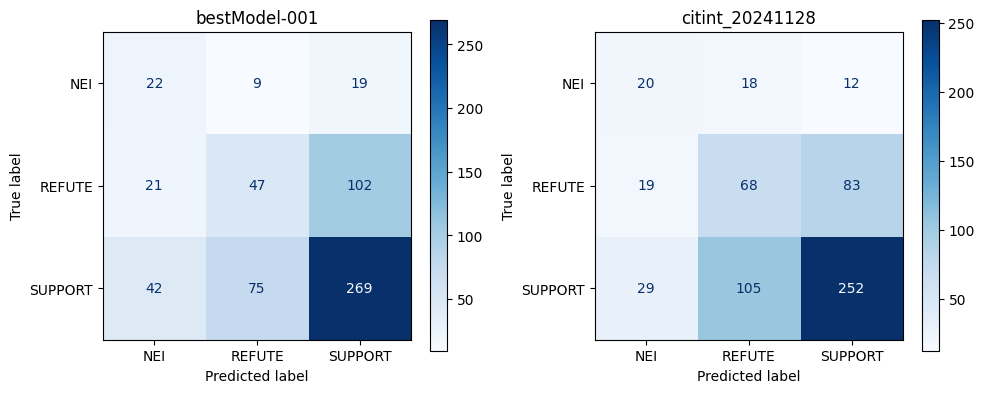

In [8]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set_title("bestModel-001")
ax[1].set_title("citint_20241128")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds[0]), display_labels=sorted(labels)).plot(ax=ax[0], cmap='Blues')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_preds[2]), display_labels=sorted(labels)).plot(ax=ax[1], cmap='Blues')
plt.tight_layout()

## Discussion

None of the models perfectly reproduces the results reported in the paper.
Some of the models approach the F1 score for SUPPORT and REFUTE, but all of them show a higher F1 for NEI compared to the paper.
Even the “best model” supplied by the authors shows lower performance in all categories except the F1 score for the ACCURATE label.

Overall, the models are not very good at predicting REFUTE or NEI labels.
One contributing factor may be class imbalance - there are many more SUPPORT labels in this dataset than other labels.
To improve the performance, I will consider training on other datasets or doing negative sampling as suggested in the MultiVerS paper.

### Number of epochs

I trained models for 5 epochs (as used in [used in Citation-Integrity](https://github.com/ScienceNLP-Lab/Citation-Integrity/blob/277152f9dfe3873455220f4cd15269474ab15617/CitationAccuracyClassificationCode/train_target.py#L52)) or 20 epochs (as used in [used in MultiVerS](https://github.com/dwadden/multivers/blob/a6ce033f0e17ae38c1f102eae1ee4ca213fbbe2e/script/train_target.py#L51)).
Considering the models I trained, training for 20 epochs (`citint_20241129`) results in better F1 scores for SUPPORT but lower scores for the other two labels, especially REFUTE.
Therefore, training for 5 epochs is probably a better choice.

### Datasets for training

Among the 5-epoch models, `citint_20241128` shows slightly better performance than `citint_20241127` for all labels.
`citint_20241128` also performs better than the “best model”, especially for REFUTE.
This may indicate that using the *dev* set rather than the *test* set in `val_dataloader` produces a model with better predictive capabilities.
The codebase for Citation-Integrity has a comment that ["did change this val_dataloader to use "Test" data"](https://github.com/ScienceNLP-Lab/Citation-Integrity/blob/277152f9dfe3873455220f4cd15269474ab15617/CitationAccuracyClassificationCode/multivers/data_train.py#L678), which was not present in the MultiVerS code.

It is still not clear to me how the *validation* dataset (also referred to as the *development* dataset) is used in model training.
Note that the *dev* dataset is not the same as the *test* set.
Here is the number of lines in each file in the Citation-Integrity dataset:

```
 316 claims_dev.jsonl
 606 claims_test.jsonl
2137 claims_train.jsonl
3063 corpus.jsonl
```

The [AI2 SciFact Leaderboard](https://leaderboard.allenai.org/scifact/submissions/get-started) describes “training on the train set alone and using the dev set for hyperparameter optimization and early stopping”, but goes on to say that the dev set can be used as additional training data.

In any case, I do not think the *test* set should be assigned to `val_dataloader`, because this data loader is used not only for validation but also for fitting, as mentioned in the [PyTorch Lightning documentation](https://lightning.ai/docs/pytorch/stable/data/datamodule.html#val-dataloader).